{0, -1}


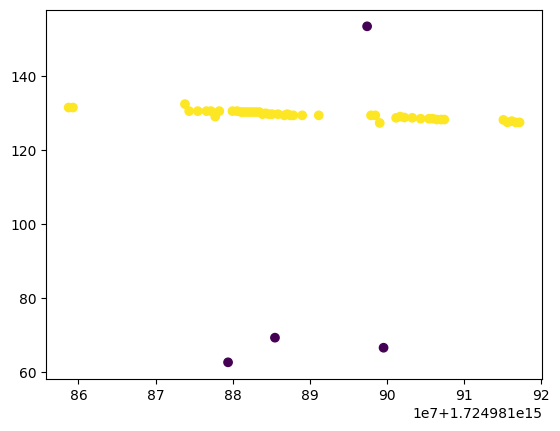

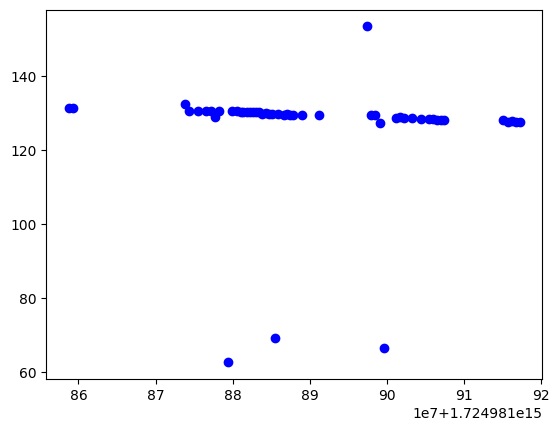

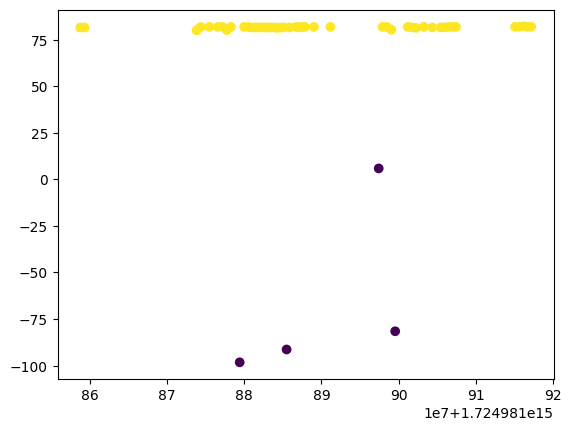

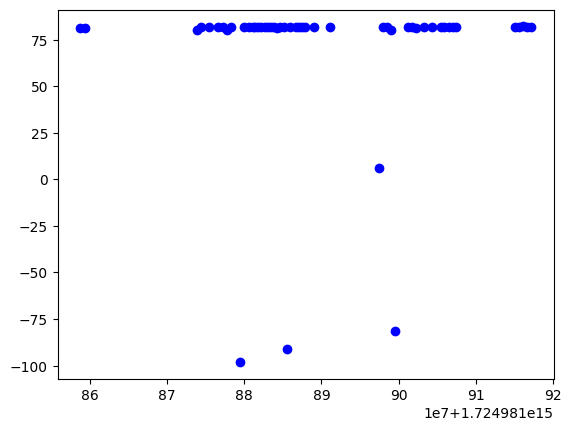

{0, -1}


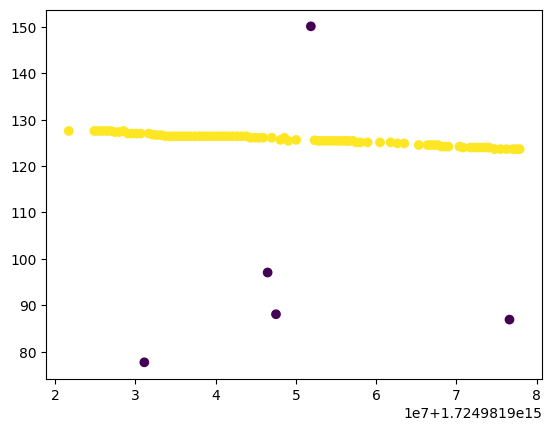

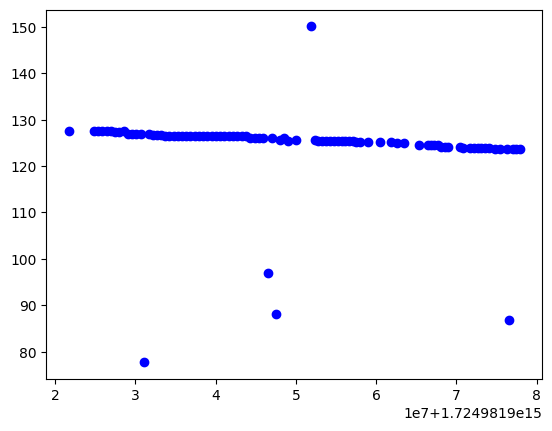

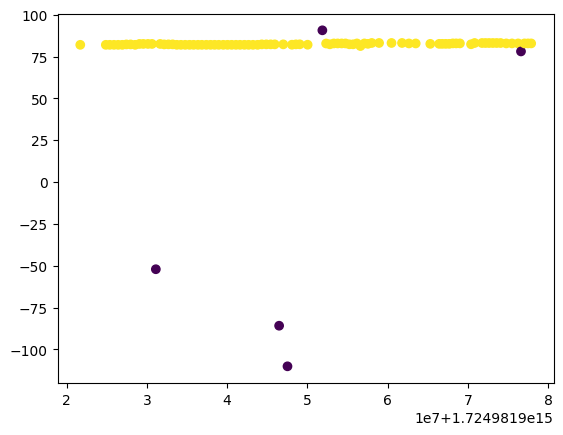

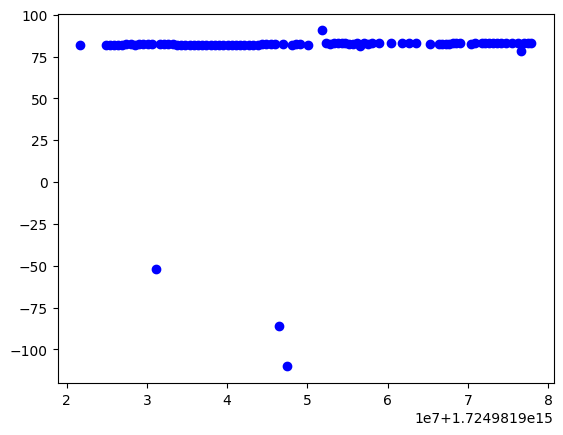

{0, 1, -1}


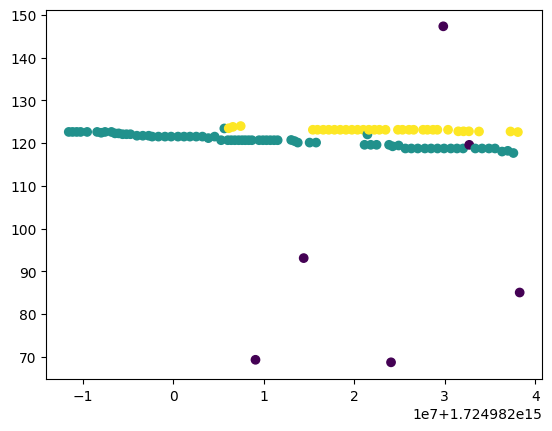

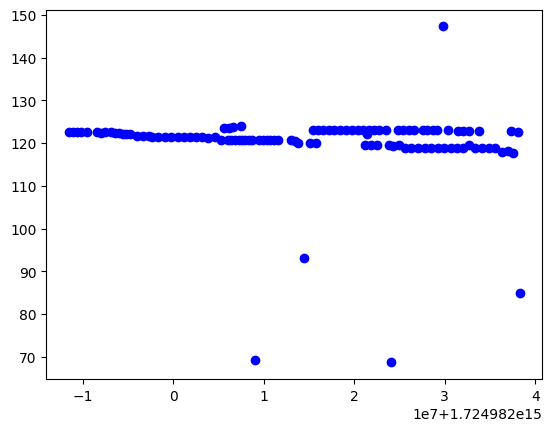

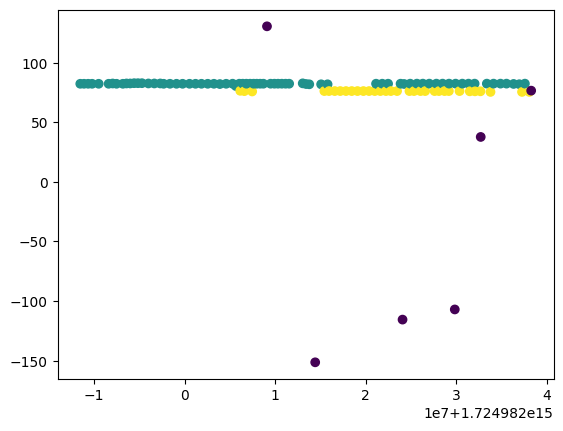

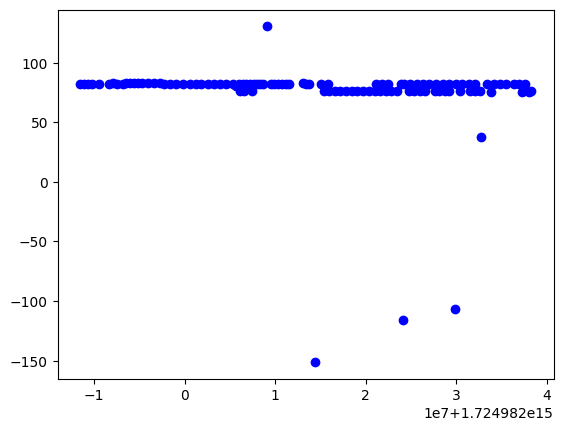

{0, 1, -1}


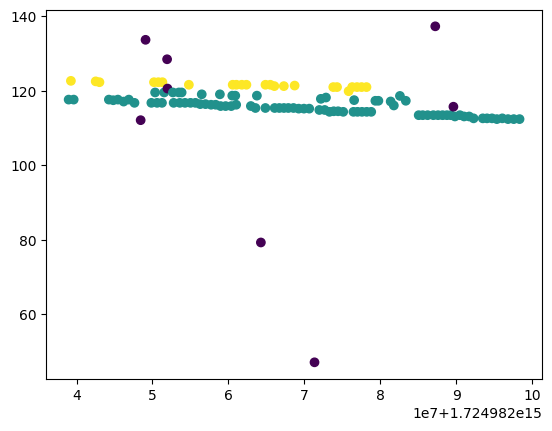

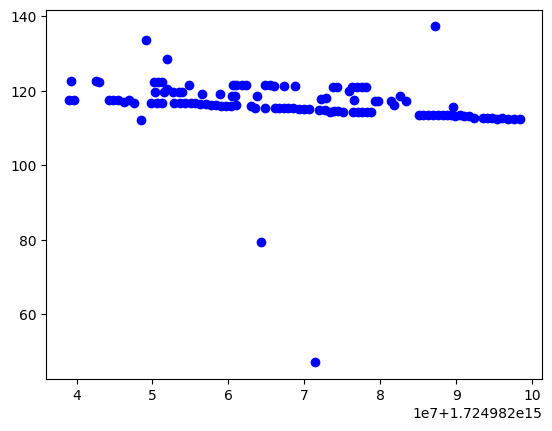

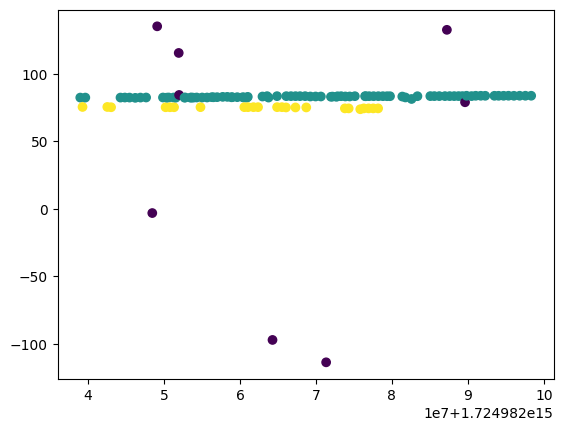

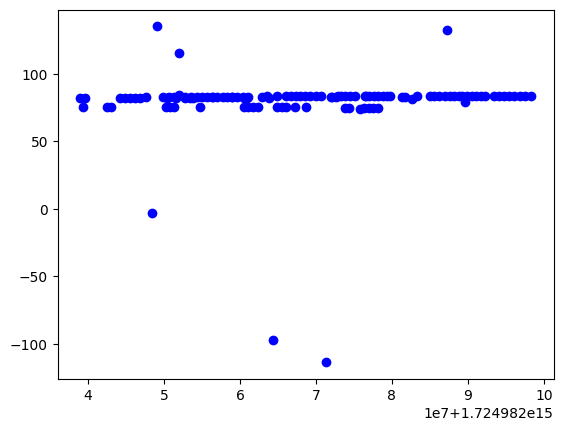

{0, -1}


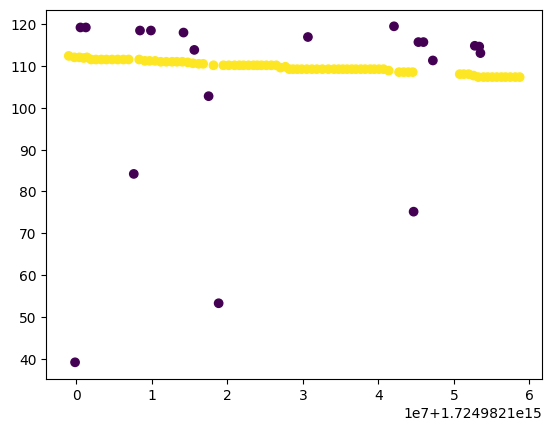

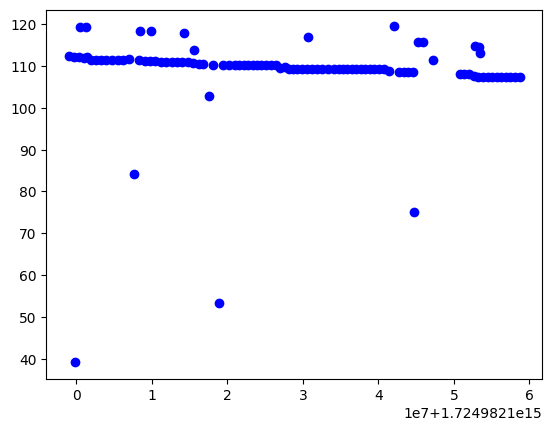

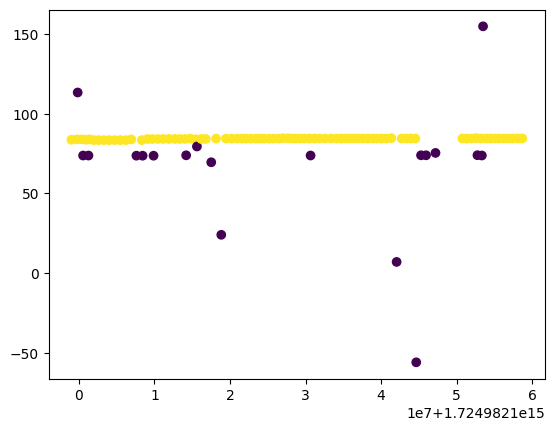

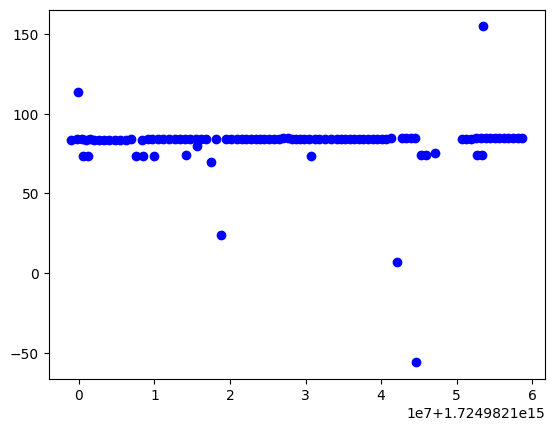

{0, -1}


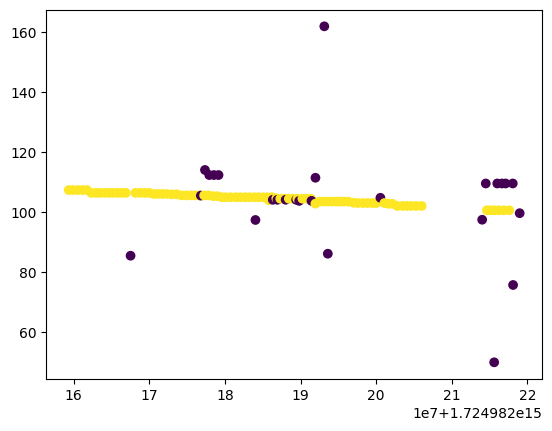

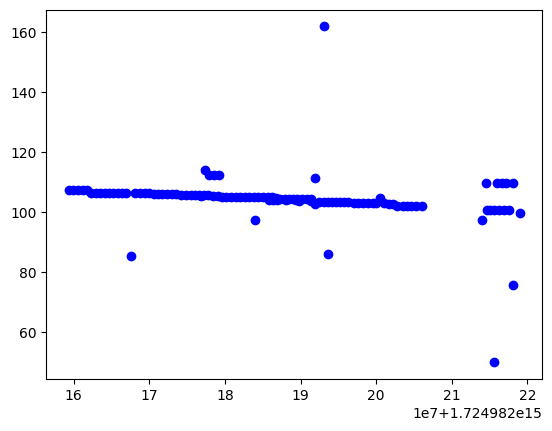

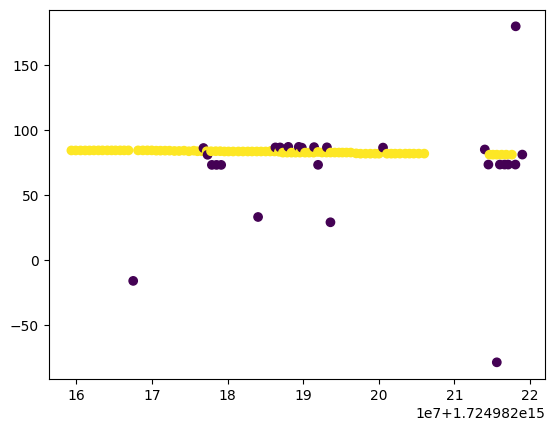

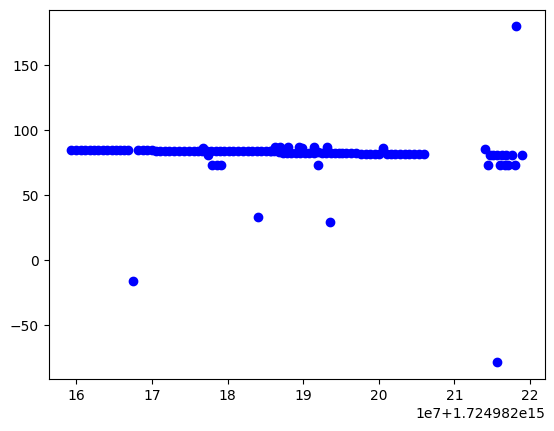

{0, 1, -1}


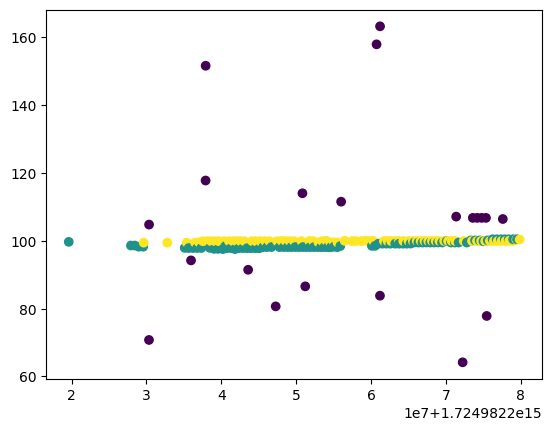

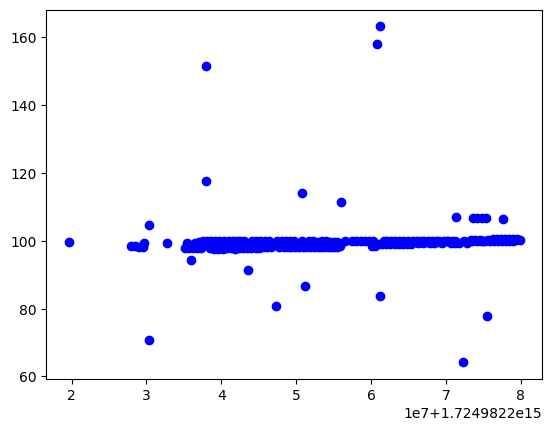

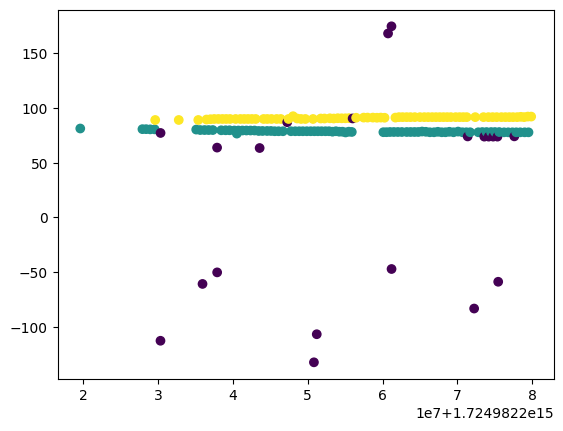

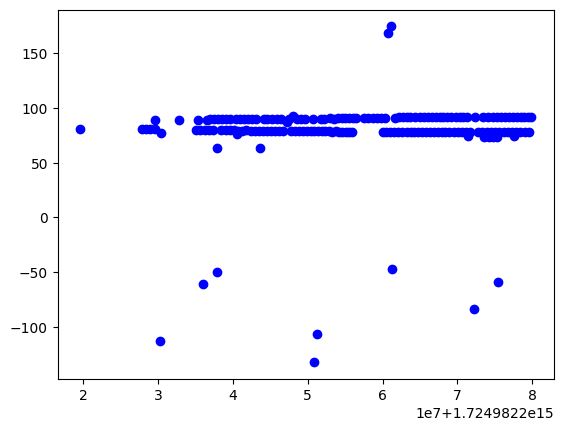

{0, 1, 2, -1}


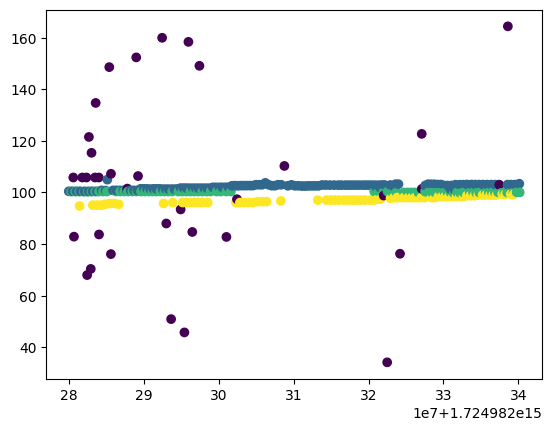

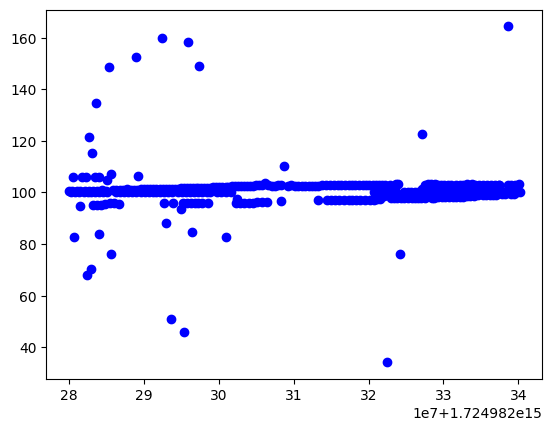

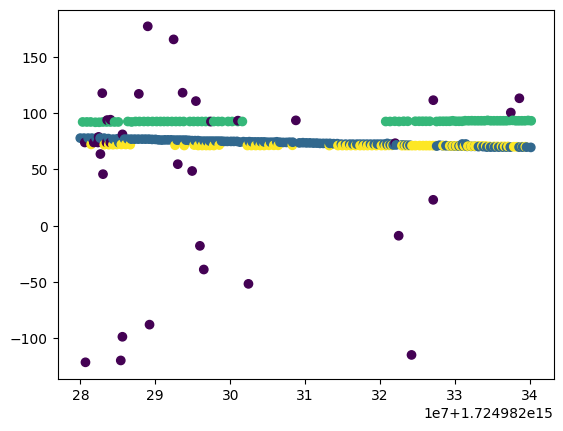

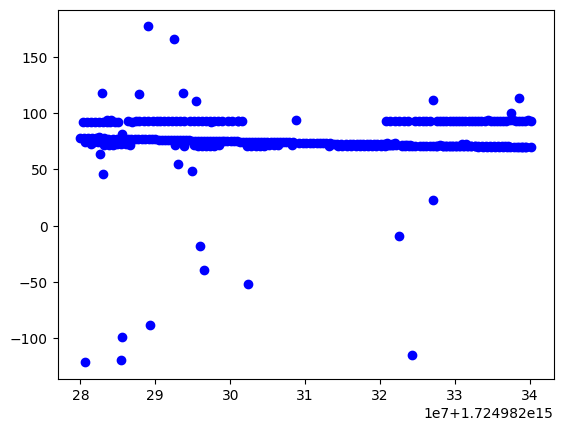

{0, 1, -1}


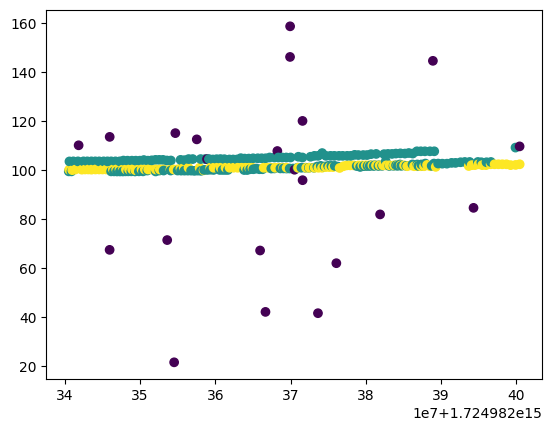

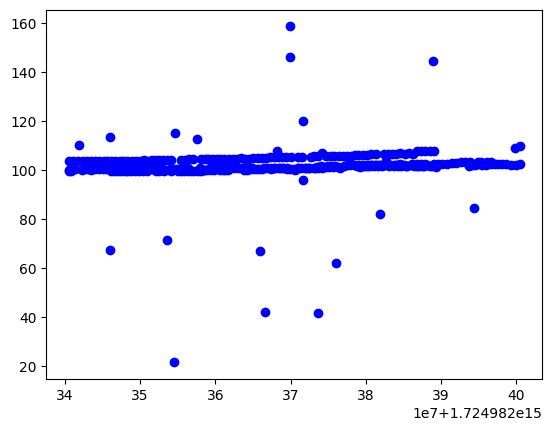

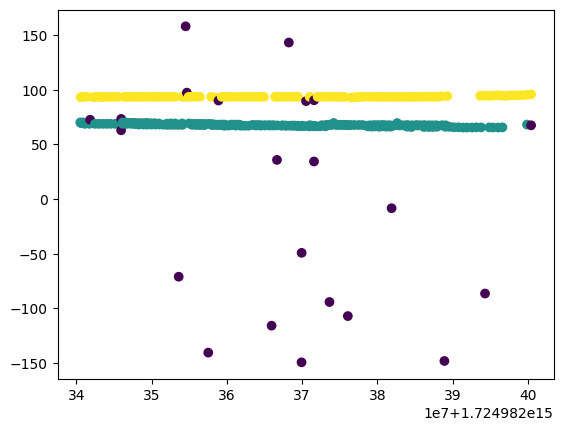

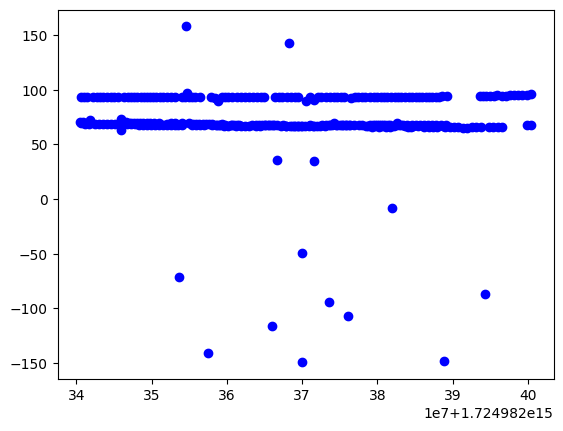

{0, 1, 2, -1}


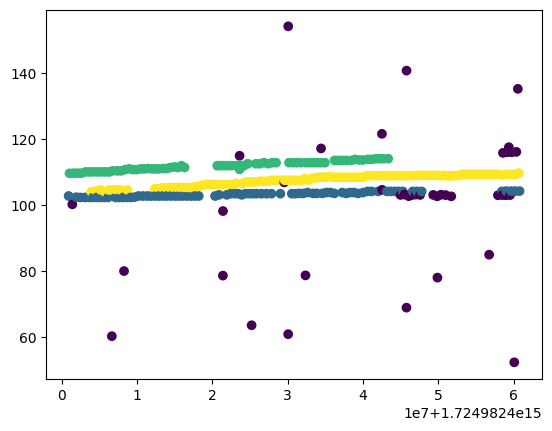

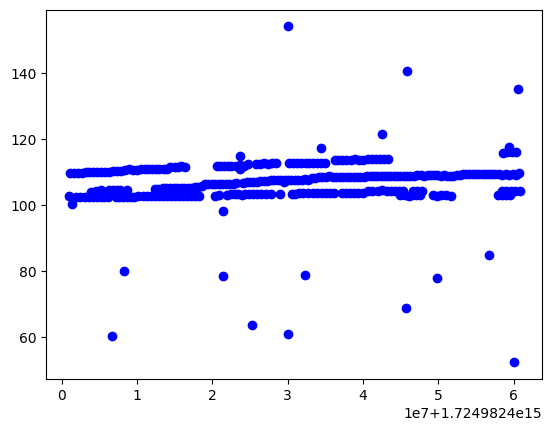

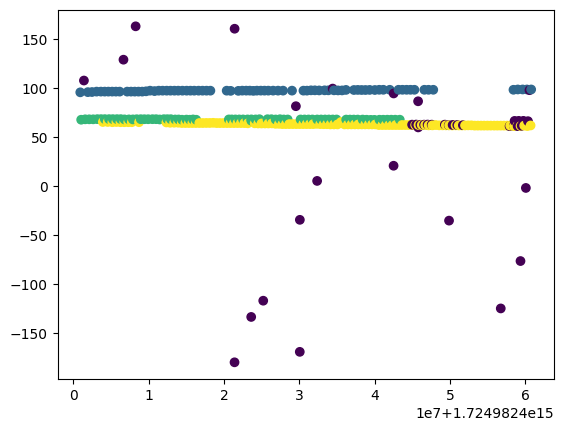

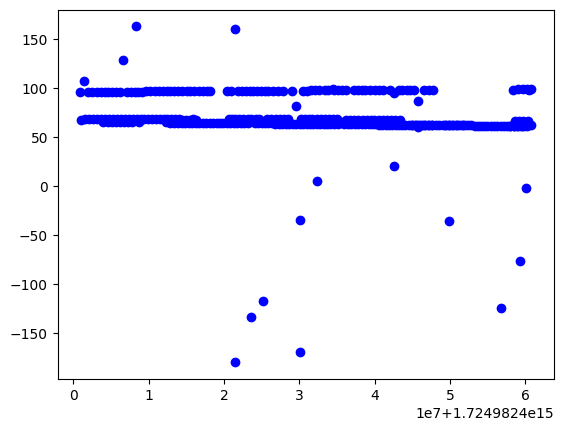

{0, 1, 2, 3, -1}


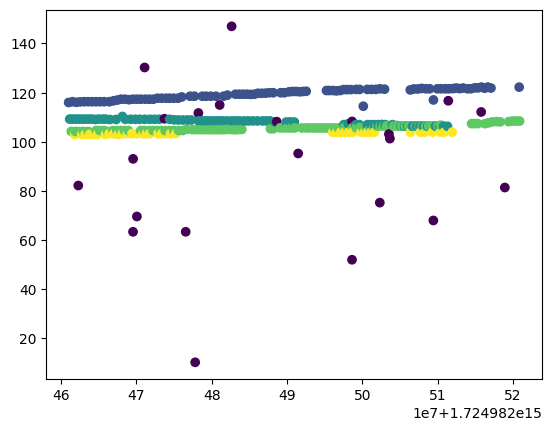

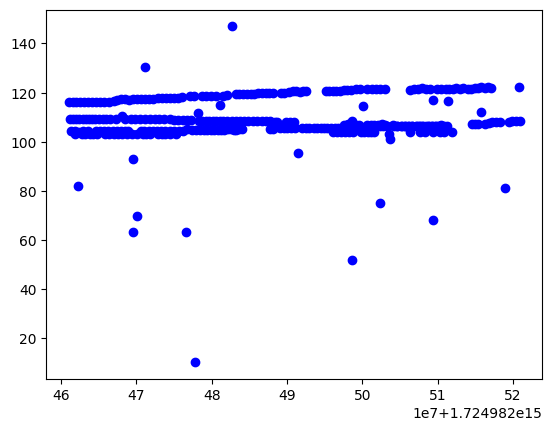

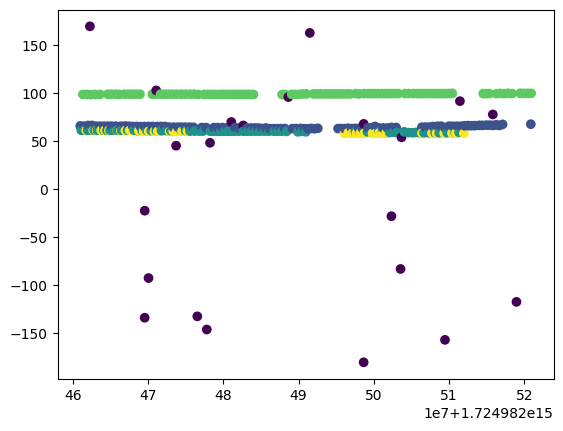

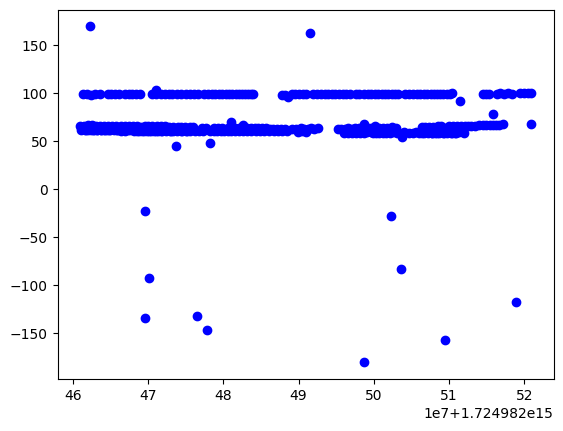

{0, 1, 2, -1}


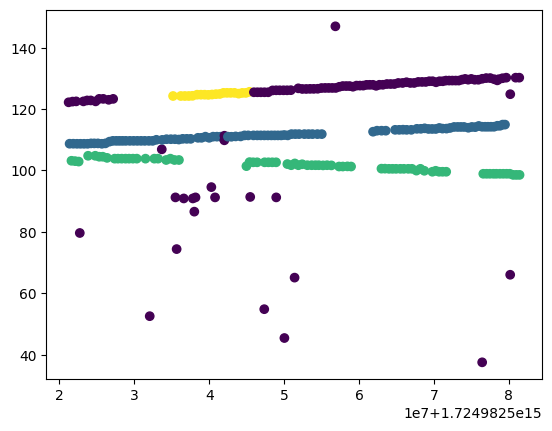

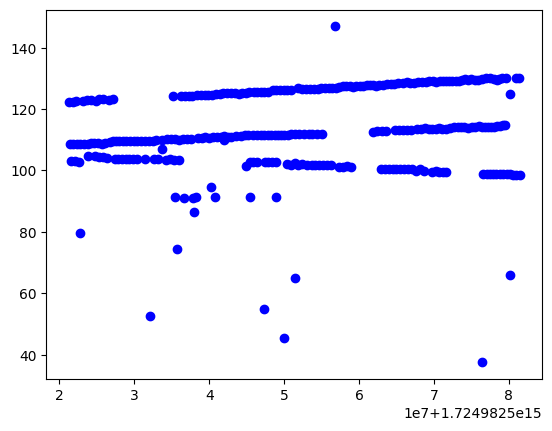

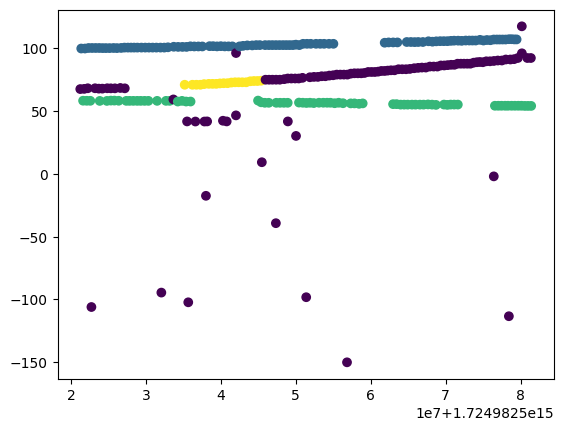

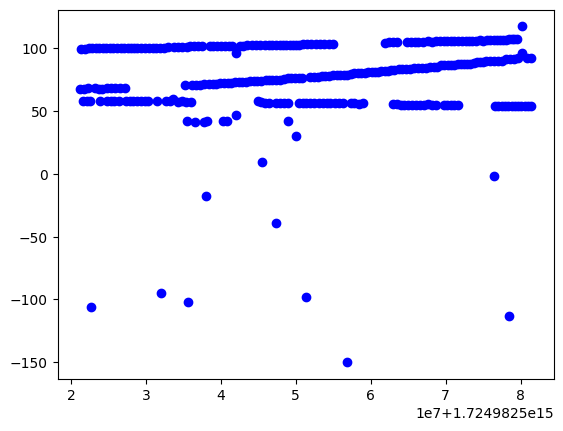

{0, 1, 2, -1}


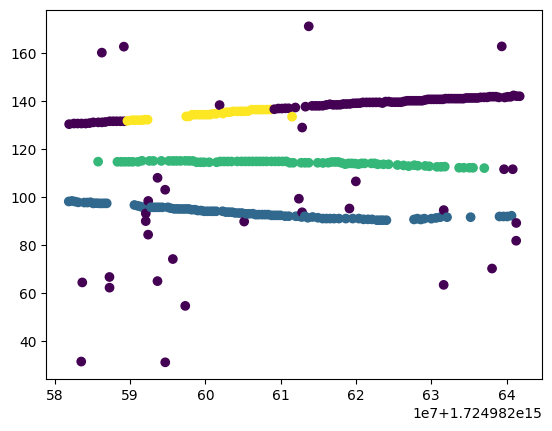

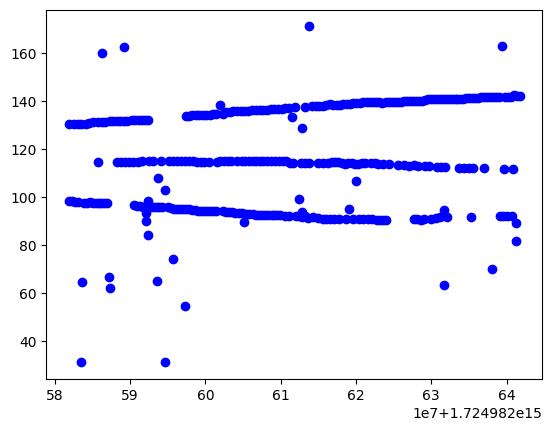

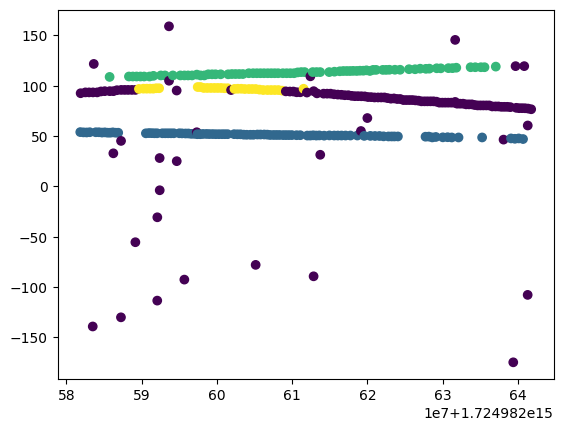

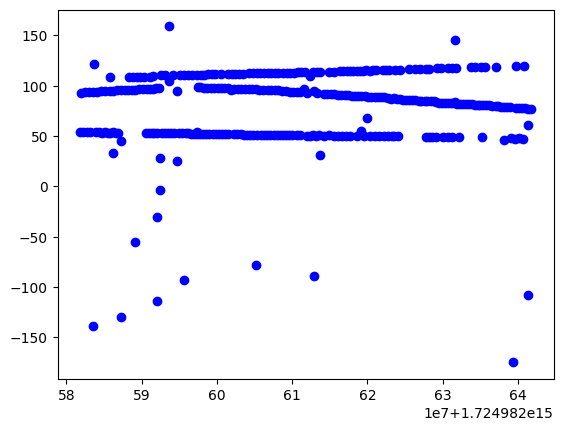

{0, 1, 2, -1}


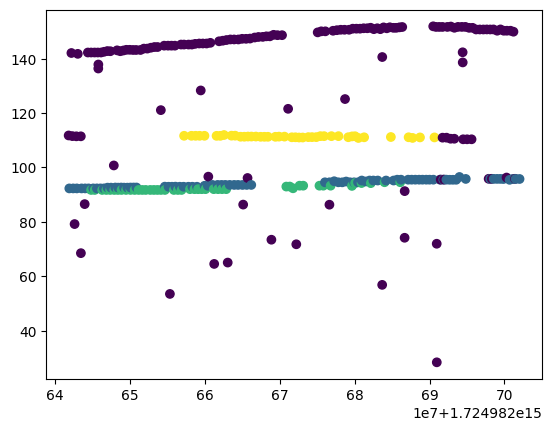

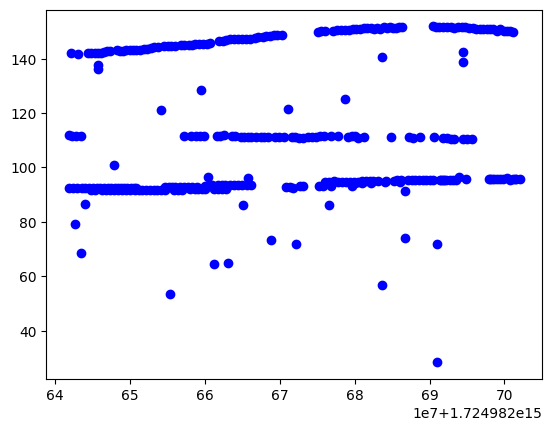

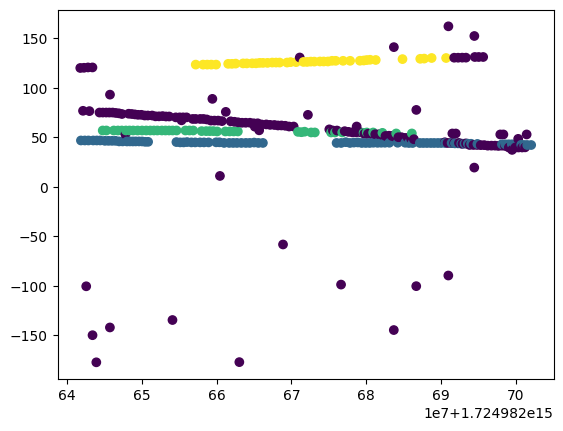

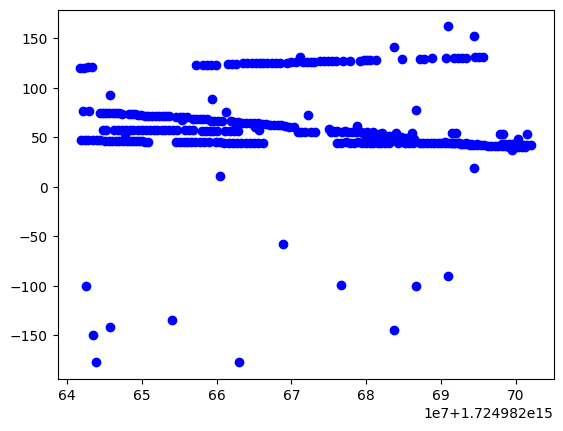

{0, 1, -1}


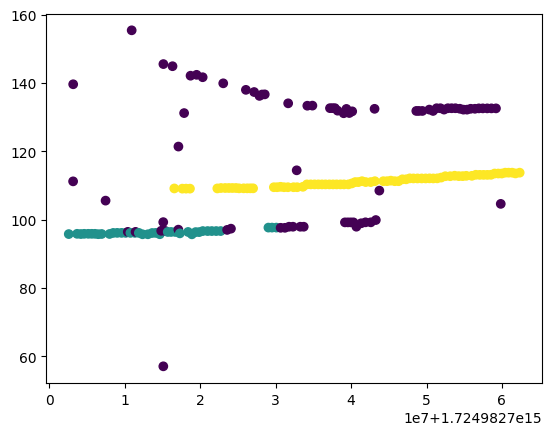

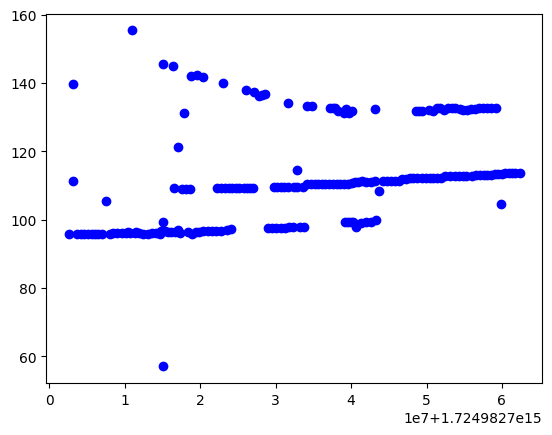

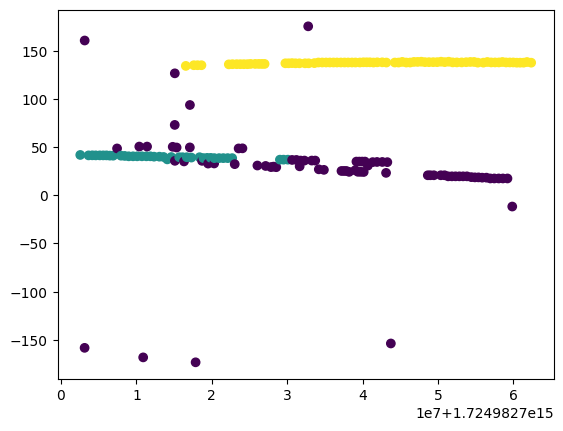

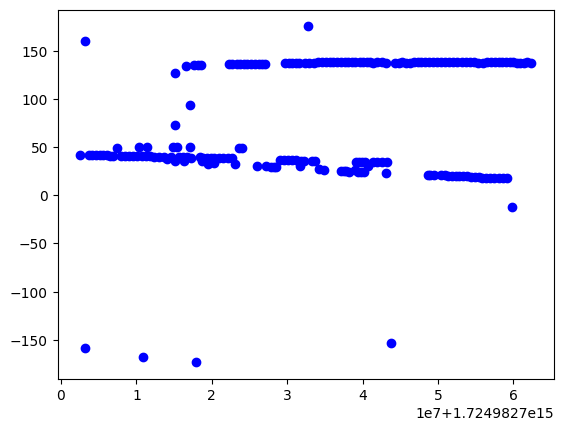

{0, -1}


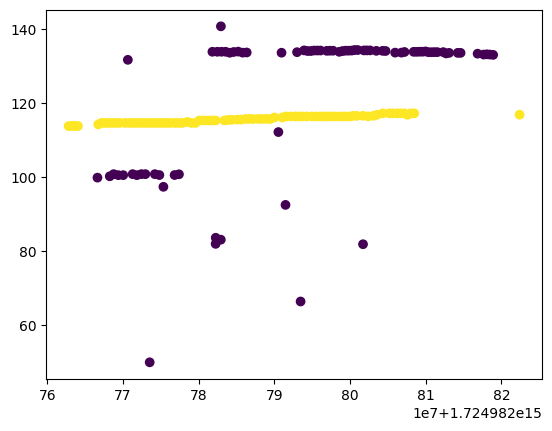

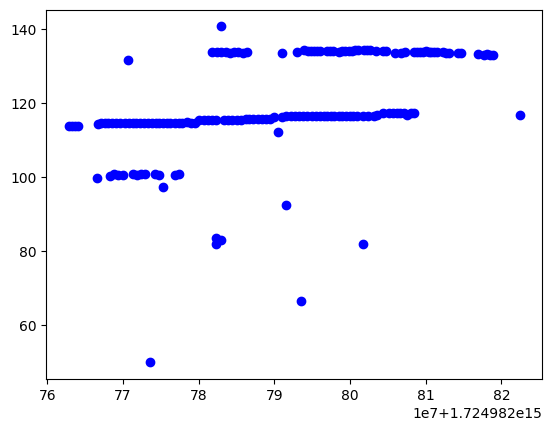

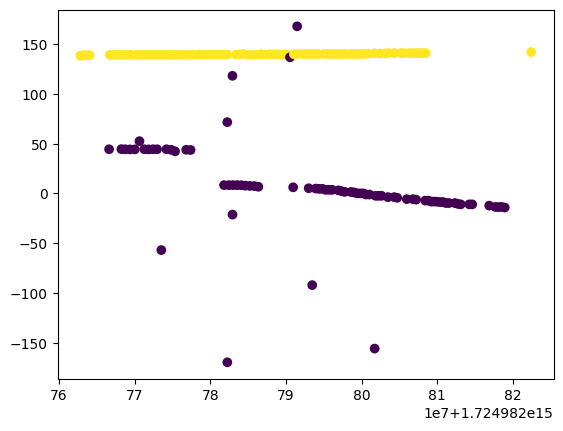

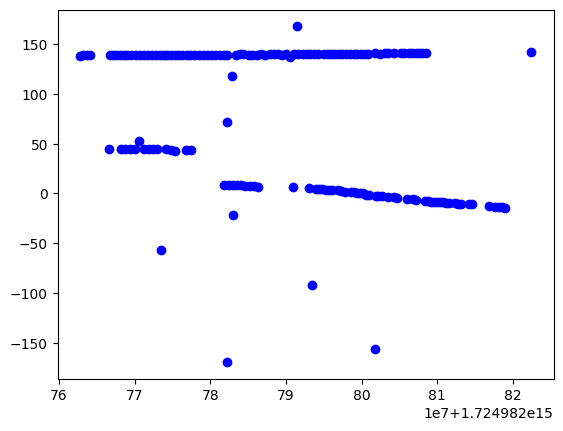

{0, 1, -1}


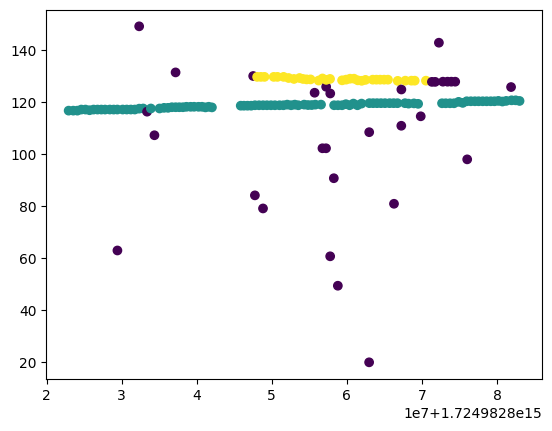

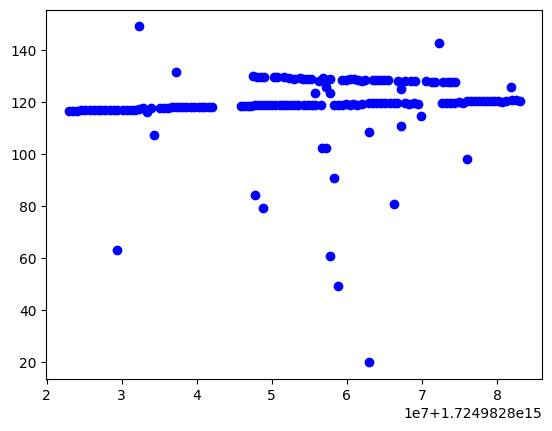

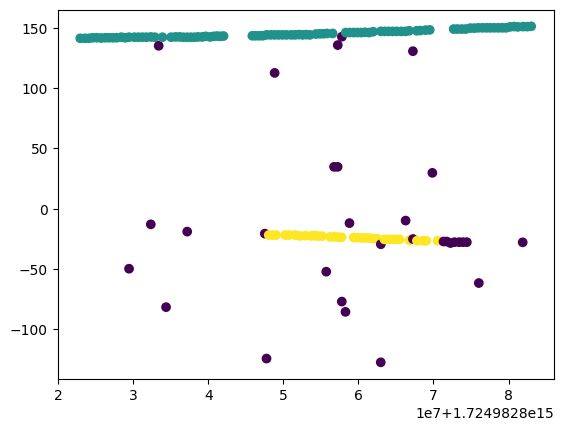

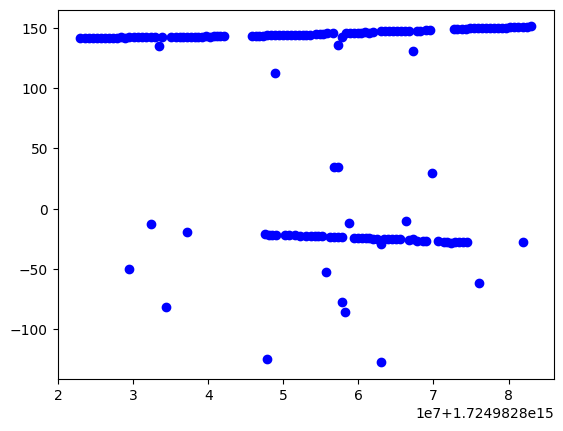

{0, 1, 2, -1}


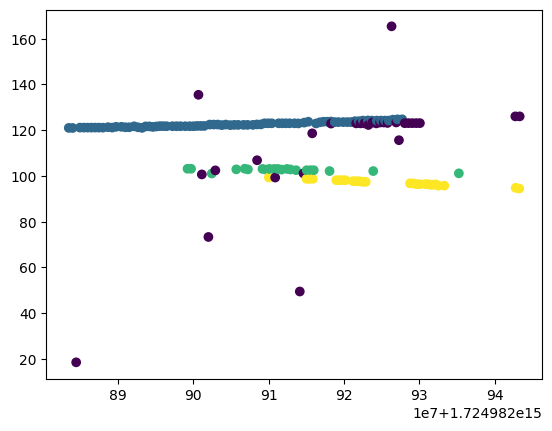

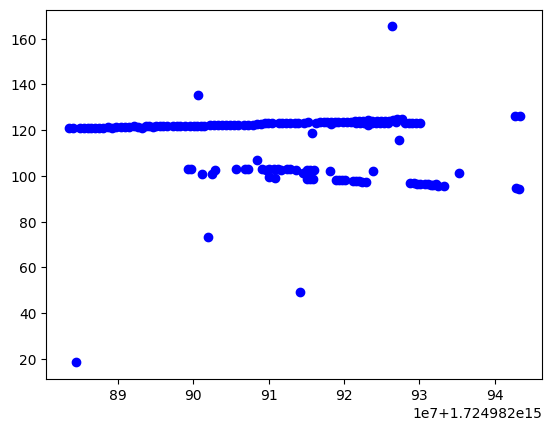

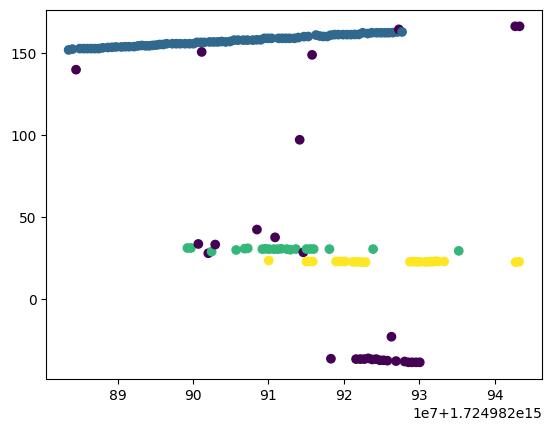

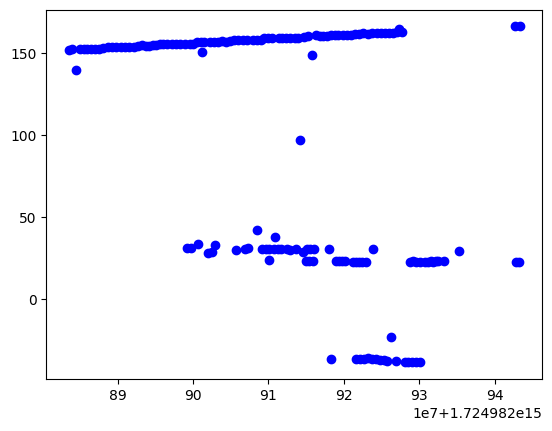

{0, 1, 2, -1}


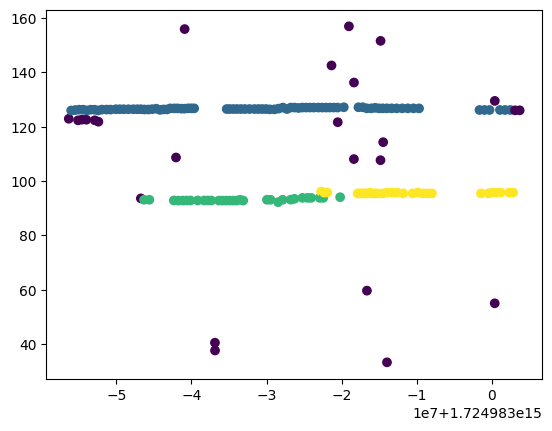

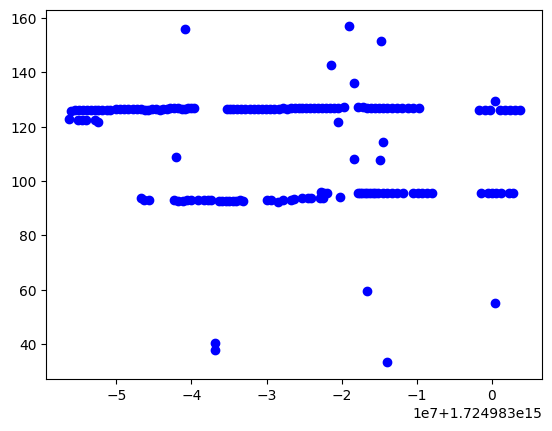

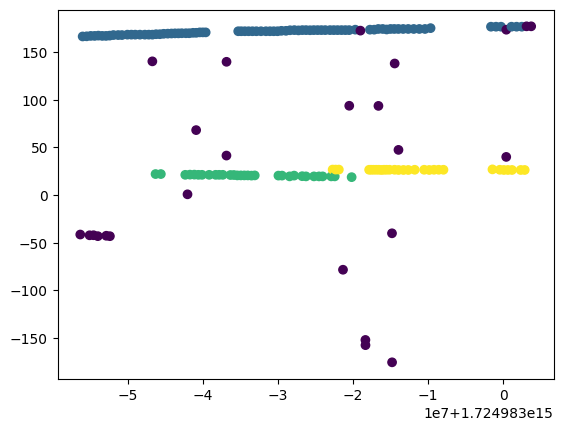

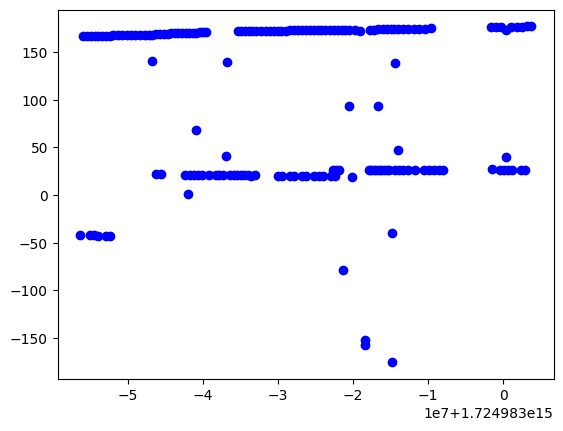

In [38]:
import numpy as np
import pandas as pd
!pip install pykalman
from sklearn.cluster import DBSCAN
from pykalman import KalmanFilter
import matplotlib.pyplot as plt

# Load the data as per your existing code
column_names = ["usec_since_Unix_Start", "Energy", "El.", "Az.", "TDOA12", "TDOA13", "TDOA14", 
                "TDOA23", "TDOA24", "TDOA34", "Xcorr12", "Xcorr13", "Xcorr14", 
                "Xcorr23", "Xcorr24", "Xcorr34"]

path_doa = "../../C/deployment_files/2024-8-29-18-37-36-480140_detection"
df = pd.read_csv(path_doa, delim_whitespace=True, names=column_names, skiprows=1)

# DBSCAN parameters
eps = 2  # Max distance between two points to be considered as in the same neighborhood
min_samples = 20  # Minimum number of points to form a cluster

# Initialize storage for Kalman filters
kalman_filters = []
cluster_assignments = []  # To track which Kalman filter corresponds to which cluster

# Function to initialize a Kalman filter given the initial position
def initialize_kalman_filter(initial_state):
    # State transition matrix: assuming constant velocity model
    transition_matrix = np.array([[1, 0, 1, 0],  # X -> X + Vx
                                  [0, 1, 0, 1],  # Y -> Y + Vy
                                  [0, 0, 1, 0],  # Vx -> Vx
                                  [0, 0, 0, 1]]) # Vy -> Vy
    
    # Observation matrix: we can only observe position, not velocity
    observation_matrix = np.array([[1, 0, 0, 0],
                                   [0, 1, 0, 0]])
    
    # Initial guess of the state covariance (uncertainty in initial position and velocity)
    initial_state_covariance = np.eye(4) * 1000
    
    # Covariance of the process noise (uncertainty in the motion model)
    process_covariance = np.eye(4) * 0.01
    
    # Covariance of the observation noise (uncertainty in the measurements)
    observation_covariance = np.eye(2) * 10
    
    # Initial state vector [X, Y, Vx, Vy]
    initial_state_mean = [initial_state[0], initial_state[1], 0, 0]  # Assuming zero initial velocity
    
    # Create the Kalman filter
    kf = KalmanFilter(
        transition_matrices=transition_matrix,
        observation_matrices=observation_matrix,
        initial_state_mean=initial_state_mean,
        initial_state_covariance=initial_state_covariance,
        transition_covariance=process_covariance,
        observation_covariance=observation_covariance
    )
    
    return kf

# Function to run DBSCAN
def run_dbscan(df):
    X = df[["El.", "Az."]].values
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    labels = db.labels_
    unique_labels = set(labels)
    print(unique_labels)
    plt.scatter(df_current["usec_since_Unix_Start"], df_current["El."], marker='o', c=labels)
    plt.show()
    plt.scatter(df_current["usec_since_Unix_Start"], df_current["El."], marker='o', color='b')
    plt.show()
    plt.scatter(df_current["usec_since_Unix_Start"], df_current["Az."], marker='o', c=labels)
    plt.show()
    plt.scatter(df_current["usec_since_Unix_Start"], df_current["Az."], marker='o', color='b')
    plt.show()
    
    return X, labels, unique_labels
    
def update_kalman_filters(X, labels, unique_labels, kalman_filters, cluster_assignments):
    for label in unique_labels:
        if label == -1:
            # Skip noise points
            continue
        
        # Find the points in the cluster
        cluster_points = X[labels == label]
        cluster_center = cluster_points.mean(axis=0)
        
        # Check if this cluster can be associated with an existing Kalman filter
        associated = False
        for idx, kf in enumerate(kalman_filters):
            # Predict the next state with the Kalman filter
            predicted_state_mean, predicted_state_covariance = kf.filter_update(
                filtered_state_mean=kf.initial_state_mean,
                filtered_state_covariance=kf.initial_state_covariance
            )
            
            # Calculate distance from the predicted state to the cluster center
            dist = np.linalg.norm(predicted_state_mean[:2] - cluster_center)
            
            if dist < eps:
                # If the cluster is close to the predicted state, update the filter
                updated_state_mean, updated_state_covariance = kf.filter_update(
                    filtered_state_mean=predicted_state_mean,
                    filtered_state_covariance=predicted_state_covariance,
                    observation=cluster_center
                )
                
                # Update the Kalman filter with the new state
                kalman_filters[idx].initial_state_mean = updated_state_mean
                kalman_filters[idx].initial_state_covariance = updated_state_covariance
                associated = True
                break
        
        if not associated:
            # If no existing filter is associated, initialize a new Kalman filter
            new_kf = initialize_kalman_filter(cluster_center)
            kalman_filters.append(new_kf)
            cluster_assignments.append(label)

# Periodically run the tracking process
time_intervals = np.linspace(df["usec_since_Unix_Start"].min(), df["usec_since_Unix_Start"].max(), num=20)
for ind in range(len(time_intervals) - 1):
    # Select the data within the current interval
    df_current = df[(df["usec_since_Unix_Start"] > time_intervals[ind]) & (df["usec_since_Unix_Start"] <= time_intervals[ind+1])]
    
    # If there are no data points in this interval, skip to the next iteration
    if df_current.empty:
        continue
    
    # Run DBSCAN
    X, labels, unique_labels = run_dbscan(df_current)
    
    # Update or initialize Kalman filters
    update_kalman_filters(X, labels, unique_labels, kalman_filters, cluster_assignments)
